# 概要：異常検知のまとめ

# 1: VGGで距離学習（L2-Softmax-Loss）

# 2: Xceptionで距離学習（L2-Softmax-Loss）

# 3: VGGでGrad-CAM

# 4: XceptionでGrad-CAM

# 5: VGGでGrad-CAM++

# 6: XceptionでGrad-CAM++

In [0]:
!cat /proc/uptime | awk '{print $1 /60 /60 "hours (" $1 "sec)"}'

0.503372hours (1812.14sec)


# 概要

- 分類モデルを用いた異常検知
  - Xception
  - VGG16
  - MobileNetV2
  - 上ほど精度が良く重い．下ほど精度が悪く軽い．
  - いずれにおいてもfine-tuning, 距離学習，GradCAMが可能

- その他の異常検知
  - Ano-GAN：学習が安定しないのでスルー
  
というわけで基本的に分類モデルを使う．しかしNG画像の多寡によって戦略は変えるべきである．

1. NG画像が十分にある場合
  - 通常の水増しを加えた上で分類モデルによる異常検知を行う
    - 精度が上がらない場合，疑似GANを用いた人工NGデータを作成して再学習する
2. NG画像が十分ではないが少しだけある場合
  - 水増しだけを用いた分類モデル
  - 疑似GAN・フランケンシュタインを用いた人工NGデータを用いた分類モデル
3. NG画像が1枚もないか，極端に少ない場合
  - DOC
  - Ano-Unet
  
# やること
  
- 通常の分類モデルとして距離学習をXception, VGG16, MobileNetV2で実施する
- GradCAM++を上記３種で行う
  - Grad-CAM++の実装コード：
  - https://github.com/totti0223/gradcamplusplus
  - Grad-CAMの系譜：
  - https://glassboxmedicine.com/2019/06/11/cnn-heat-maps-class-activation-mapping-cam/
  
  
- FineTuningを上記３種で行う
- 擬似GANによるNG画像追加による効果を検証する
  
# 最終パッケージ

- GUIつき
- ワンクリックで学習・最適化が完了する
- ワンクリックで推定・異常部位の提示が可能
- 
  
  

# 3: VGGでGrad-CAM

# qiita: https://qiita.com/bele_m/items/a7bb15313e2a52d68865

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16()

W0901 08:32:21.904876 140398205187968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


553467904/553467096 [==============================] - 13s 0us/step


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd ./gdrive/'My Drive'/"Colab Notebooks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [0]:
import numpy as np
from tensorflow.keras.preprocessing import image
image_name = "elephant"
filename = "elephant.jpg".format(image_name)  # 画像のパスを指定
img = image.load_img(filename, target_size=(224, 224))
x_orig = image.img_to_array(img)  # ndarray: (224, 224, 3), float32
x = np.expand_dims(x_orig, axis=0)  # ndarray: (1, 224, 224, 3), float32

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
x_processed = preprocess_input(x)  # ndarray: (1, 224, 224, 3), float32
y_pred = model.predict(x_processed)  # ndarray: (1, 1000), float32

from tensorflow.keras.applications.vgg16 import decode_predictions
results = decode_predictions(y_pred, top=5)[0]  # (クラス名, クラス表記, スコア)のリスト
for result in results:
    print(result)
ranking = y_pred[0].argsort()[::-1]
class_idx = ranking[0]

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
class_output = model.output[:, class_idx]  # Tensor / クラススコア
grad_tensor = K.gradients(class_output, model.input)[0]  # Tensor / クラススコアに対する入力の勾配
grad_func = K.function([model.input], [grad_tensor])  # Function / 勾配の値を算出するための関数
gradient = grad_func([x_processed])[0][0]  # ndarray: (224, 224, 3), float32 / 算出された勾配の値

40960/35363 [==================================] - 0s 0us/step
('n02504458', 'African_elephant', 0.9790476)
('n02504013', 'Indian_elephant', 0.020239765)
('n01871265', 'tusker', 0.00070636644)
('n02437312', 'Arabian_camel', 3.7133047e-06)
('n01704323', 'triceratops', 1.8734703e-06)


# GradCAM

In [0]:
import cv2
convout_tensor = model.get_layer("block5_conv3").output  # convolutionの出力/Tensor

grad_tensor = K.gradients(class_output, convout_tensor)[0]  # 勾配/Tensor
grad_func = K.function([model.input], [convout_tensor, grad_tensor])  #勾配を算出する関数
convout_val, grads_val = grad_func([x_processed])
convout_val, grads_val = convout_val[0], grads_val[0]  # array: (14, 14, 512), float32 (両方とも）

weights = np.mean(grads_val, axis=(0,1))  # チャネルの重み/array: (512,), float32
grad_cam = np.dot(convout_val, weights)  # 畳み込みの出力をチャネルで重みづけ/array, (14, 14), float32
grad_cam = np.maximum(grad_cam, 0)
grad_cam = cv2.resize(grad_cam, (224, 224), cv2.INTER_LINEAR)  # 上記をリサイズ

In [0]:
def visualize_mono_map(map_array, base_image=None, output_path=None):
    if map_array.ndim == 3:
        mono_map = np.sum(np.abs(map_array), axis=2)  # マップがカラーだった場合はモノクロに変換する
    else:
        mono_map = map_array

    # マップを正規化（上位・下位10%の画素は見やすさのため飽和させる）
    minimum_value = np.percentile(mono_map, 10)
    maximum_value = np.percentile(mono_map, 90)
    normalized_map = (np.minimum(mono_map, maximum_value) - minimum_value) / (maximum_value - minimum_value) 
    normalized_map = np.maximum(normalized_map, 0.)

    if base_image is None:
        plt.imshow(normalized_map, cmap='jet')

    else:
        image_norm = (base_image - base_image.min()) / (base_image.max() - base_image.min())  # 背景画像の正規化
        overlay = np.stack([normalized_map * image_norm[:,:,i] for i in range(3)], axis=2)
        plt.imshow(overlay)

    if output_path is None:
        plt.show()
    else:
        plt.savefig(output_path)

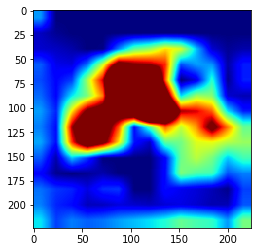

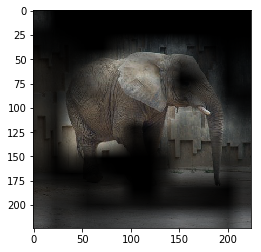

In [8]:
visualize_mono_map(grad_cam)
visualize_mono_map(grad_cam, x_orig)

# 1: VGGで距離学習（L2-Softmax-Loss）

# 元ネタ：https://qiita.com/shinmura0/items/06d81c72601c7578c6d3

# qiita: https://qiita.com/shinmura0/items/06d81c72601c7578c6d3

# 5: VGGでGrad-CAM++

# qiita: https://qiita.com/bele_m/items/a7bb15313e2a52d68865

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd ./gdrive/'My Drive'/"Colab Notebooks"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: './gdrive/My Drive/Colab Notebooks'
/content/gdrive/My Drive/Colab Notebooks


In [10]:
import pandas as pd
import numpy as np
import cv2
import argparse
import keras
import time
import sys
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50

K.set_learning_phase(1)


def Grad_Cam_plus_plus(input_model, layer_name, x, row, col):
    '''
    Args:
       input_model: ResNet50のモデル
       x: 画像(array)
       layer_name: 畳み込み層の名前
       (row, col): 画像のサイズ
    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)
    '''

    model = input_model

    #前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0


    #予測クラスの算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])

    #使用する重みの抽出、高階微分の計算
    class_output = model.layers[-1].output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    #first_derivative：１階微分
    first_derivative = K.exp(class_output)[0][class_idx] * grads
    #second_derivative：２階微分
    second_derivative = K.exp(class_output)[0][class_idx] * grads * grads
    #third_derivative：３階微分
    third_derivative = K.exp(class_output)[0][class_idx] * grads * grads * grads

    #関数の定義
    gradient_function = K.function([model.input], [conv_output, first_derivative, second_derivative, third_derivative])  # model.inputを入力すると、conv_outputとgradsを出力する関数


    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = gradient_function([preprocessed_input])
    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = conv_output[0], conv_first_grad[0], conv_second_grad[0], conv_third_grad[0]

    #alphaを求める
    global_sum = np.sum(conv_output.reshape((-1, conv_first_grad.shape[2])), axis=0)
    alpha_num = conv_second_grad
    alpha_denom = conv_second_grad*2.0 + conv_third_grad*global_sum.reshape((1,1,conv_first_grad.shape[2]))
    alpha_denom = np.where(alpha_denom!=0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    #alphaの正規化
    alpha_normalization_constant = np.sum(np.sum(alphas, axis = 0), axis = 0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad.shape[2]))

    #wの計算
    weights = np.maximum(conv_first_grad, 0.0)
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad.shape[2])))

    #Lの計算
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output, axis=2)
    grad_CAM_map = np.maximum(grad_CAM_map, 0)
    grad_CAM_map = grad_CAM_map / np.max(grad_CAM_map)

    #ヒートマップを描く
    grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
    jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return jetcam

model = ResNet50(weights = 'imagenet')
target_layer = 'activation_49'
image_path = 'cat_dog.png'
row = 224
col = 224

img = img_to_array(load_img(image_path,target_size=(row,col)))
img_GCAMplusplus = Grad_Cam_plus_plus(model, target_layer, img, row, col)
time = time.ctime()
img_Gplusplusname = image_path+time+"_GCAM++_%s.jpg"
cv2.imwrite(img_Gplusplusname, img_GCAMplusplus)
print("Completed.")

Using TensorFlow backend.
W0901 09:02:19.319183 140398205187968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 09:02:19.326000 140398205187968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 09:02:19.338804 140398205187968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0901 09:02:19.372866 140398205187968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inste

102858752/102853048 [==============================] - 3s 0us/step
Completed.


W0901 09:09:06.699725 140398205187968 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


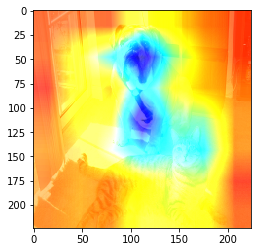

In [15]:
import matplotlib.pyplot as plt

plt.imshow(img_GCAMplusplus/255)
plt.show()

W0901 09:16:14.760078 140398205187968 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


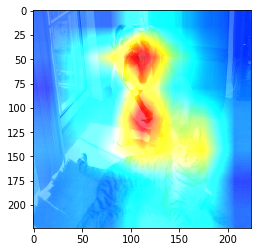

In [20]:
import cv2

im_rgb = cv2.cvtColor(img_GCAMplusplus/255, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

In [21]:
np.max(img_GCAMplusplus)

382.5

In [22]:
np.min(img_GCAMplusplus)

0.0